In [1]:
import pandas as pd
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '/home/jabez_kassa/week_9/Crypto-Trading-Engineering/scripts'))
import forecast
import db_conn

/home/jabez_kassa/week_9/Crypto-Trading-Engineering/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
conn = psycopg2.connect(
    dbname="historical_data",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)


In [19]:
# Get DataFrames from database
df_btc = db_conn.get_df_from_db(conn, 'btc_data')
df_bnb = db_conn.get_df_from_db(conn, 'bnb_data')
df_eth = db_conn.get_df_from_db(conn, 'eth_data')
df_sol = db_conn.get_df_from_db(conn, 'sol_data')
df_xrp = db_conn.get_df_from_db(conn, 'xrp_data')

/home/jabez_kassa/week_9/Crypto-Trading-Engineering/env/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Forecast Dates Range: 2024-06-21 00:00:00 to 2024-07-02 00:00:00


<module 'matplotlib.pyplot' from '/home/jabez_kassa/week_9/Crypto-Trading-Engineering/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

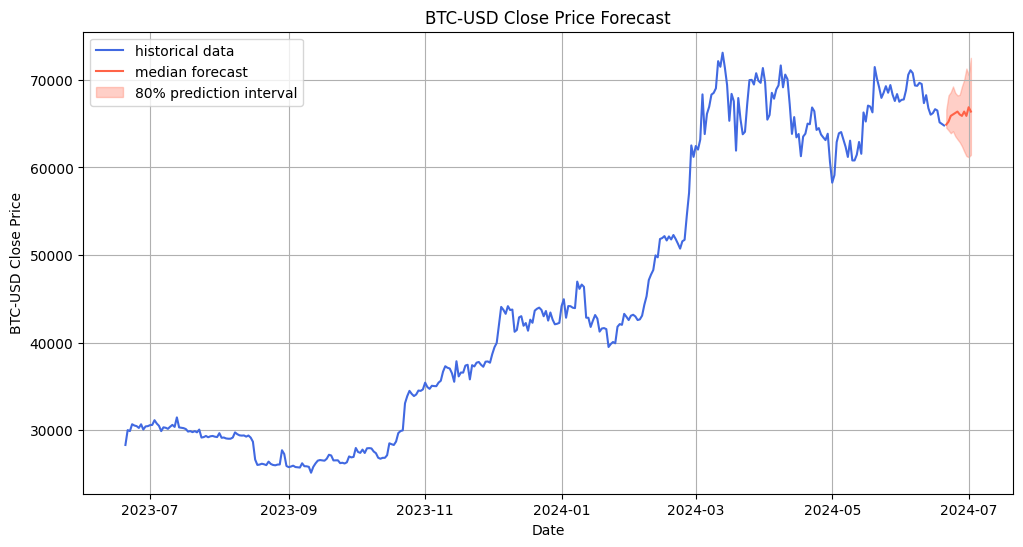

In [7]:
name = 'BTC'
context = forecast.data_preparation(df_btc)
forecast_dates = forecast.generate_forecast_dates(df_btc)
forecast.predict("BTC", df_btc, forecast_dates, context)

/home/jabez_kassa/week_9/Crypto-Trading-Engineering/env/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Forecast Dates Range: 2024-06-21 00:00:00 to 2024-07-02 00:00:00


<module 'matplotlib.pyplot' from '/home/jabez_kassa/week_9/Crypto-Trading-Engineering/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

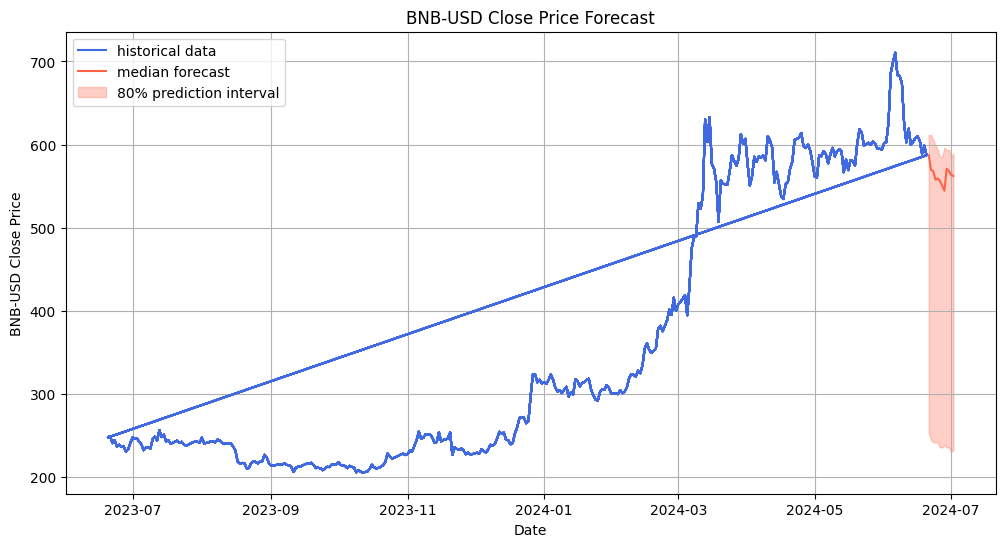

In [13]:
name = 'BNB'
context_bnb = forecast.data_preparation(df_bnb)
forecast_bnb_date = forecast.generate_forecast_dates(df_bnb)
forecast.predict(name, df_bnb,forecast_bnb_date,context_bnb)

/home/jabez_kassa/week_9/Crypto-Trading-Engineering/env/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Forecast Dates Range: 2024-06-21 00:00:00 to 2024-07-02 00:00:00


<module 'matplotlib.pyplot' from '/home/jabez_kassa/week_9/Crypto-Trading-Engineering/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

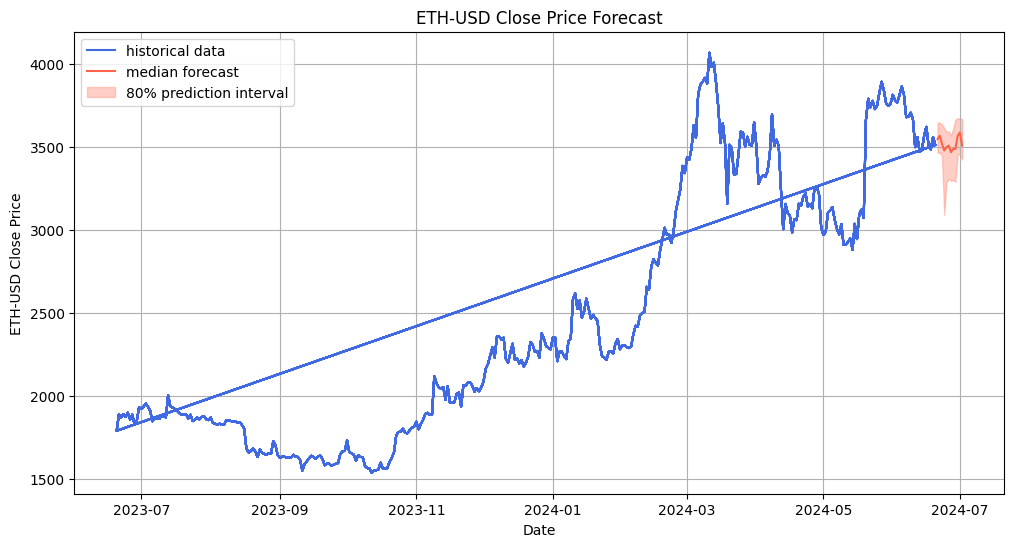

In [17]:
name = 'ETH'
context_eth = forecast.data_preparation(df_eth)
forecast_eth_date = forecast.generate_forecast_dates(df_eth)
forecast.predict(name, df_eth,forecast_eth_date,context_eth)

/home/jabez_kassa/week_9/Crypto-Trading-Engineering/env/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Forecast Dates Range: 2024-06-21 00:00:00 to 2024-07-02 00:00:00


<module 'matplotlib.pyplot' from '/home/jabez_kassa/week_9/Crypto-Trading-Engineering/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

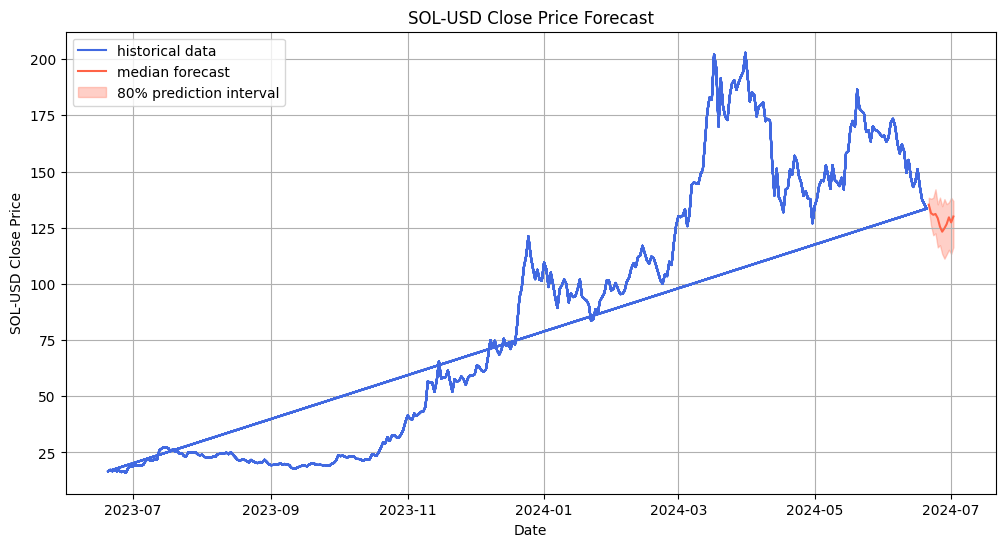

In [20]:
name = 'SOL'
context_sol = forecast.data_preparation(df_sol)
forecast_sol_date = forecast.generate_forecast_dates(df_sol)
forecast.predict(name, df_sol,forecast_sol_date,context_sol)

/home/jabez_kassa/week_9/Crypto-Trading-Engineering/env/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Forecast Dates Range: 2024-06-21 00:00:00 to 2024-07-02 00:00:00


<module 'matplotlib.pyplot' from '/home/jabez_kassa/week_9/Crypto-Trading-Engineering/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

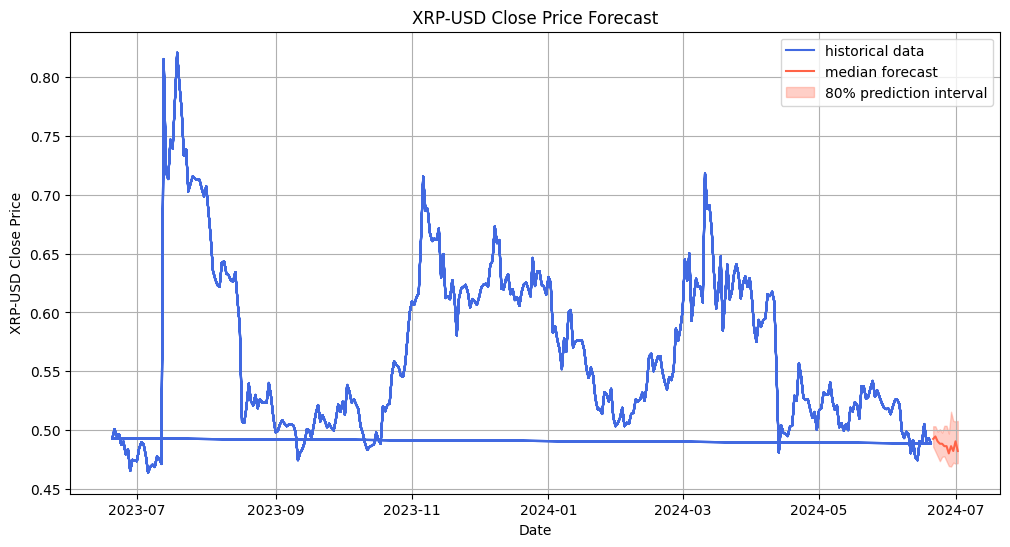

In [21]:
name = 'XRP'
context_xrp = forecast.data_preparation(df_xrp)
forecast_xrp_date = forecast.generate_forecast_dates(df_xrp)
forecast.predict(name, df_xrp,forecast_xrp_date,context_xrp)